# 1. Introducción

## 1.1 Antecedentes
En la industria de la construcción, los problemas de calidad como la mano de obra deficiente, la documentación incompleta y el incumplimiento de materiales con frecuencia provocan costosos retrasos, retrabajos y disputas. A pesar del uso de herramientas modernas de gestión de proyectos e inspecciones rutinarias, muchos problemas todavía se identifican de forma reactiva, es decir, solo después de que ya han causado interrupciones.

Como gerente de construcción e investigador, he observado el potencial no aprovechado en los datos administrativos generados diariamente en los sitios de construcción. Esto incluye registros de tareas y formularios diarios presentados por el personal de campo. Aprovechar estos datos con aprendizaje automático ofrece una oportunidad para pasar de la detección reactiva de problemas a la predicción proactiva de riesgos.

## 1.2 Objetivo del Proyecto
Este proyecto explora si el aprendizaje automático puede utilizarse para predecir posibles problemas de calidad en proyectos de construcción usando datos administrativos estructurados, sin depender de sensores, fotos o modelos BIM.

El objetivo principal es:

Construir un modelo de aprendizaje automático que prediga si un registro de tarea recién enviado probablemente indique un problema de calidad, utilizando características como grupo de tareas (por ejemplo, Seguridad, QA/QC), causa (por ejemplo, Documentación, Limpieza), nivel de prioridad y estado de vencimiento.

## 1.3 Pregunta de Investigación Clave
¿Podemos usar datos administrativos rutinarios de construcción para predecir posibles problemas de calidad antes de que ocurran?

Si tiene éxito, este proyecto permitirá:

- Proporcionar una solución escalable y de bajo costo usando datos que ya se recopilan.
- Empoderar a los equipos de campo con información inteligente basada en datos.
- Reducir riesgos, retrabajos y retrasos en proyectos de cualquier tamaño.

# 2. Comprensión del Conjunto de Datos

## 2.1 Descripción del Dataset
El conjunto de datos utilizado en este proyecto se titula “Construction and Project Management Example Data”, obtenido de Kaggle. Consta de dos componentes principales:

- Formularios y reportes diarios presentados por el personal de campo (por ejemplo, diarios de obra, planes de trabajo).
- Registros de tareas, que incluyen:
  - Tipo de tarea
  - Grupo de tarea (por ejemplo, Seguridad, QA/QC)
  - Causa (por ejemplo, Documentación, Limpieza)
  - Estado de vencimiento
  - Nivel de prioridad
  - Estado (Abierto/Cerrado)

Cada registro en este dataset refleja actividades reales en campo, lo que lo hace altamente relevante para el modelado de riesgos de calidad.

## 2.2 Por Qué Este Dataset Es Relevante
Este conjunto de datos es ideal para construir un modelo predictivo porque:

- Captura la toma de decisiones operativas en tiempo real a nivel de campo.
- Incluye indicadores operativos como Causa, Vencido y Prioridad, comúnmente monitoreados por gerentes de calidad.
- No requiere herramientas ni hardware adicionales de recolección de datos — solo análisis de registros existentes.

**Ejemplos:**

- Las tareas marcadas como "Alta" prioridad suelen indicar preocupaciones urgentes de calidad o seguridad.
- Causas como "Documentación" o "Limpieza" aparecen con frecuencia en reportes de no conformidad.
- Las tareas vencidas pueden indicar retrasos en la resolución de problemas críticos.

Estas características son fuertes predictores para identificar riesgos potenciales.

# 3. Enfoque del Problema

## 3.1 Tipo de Problema de Machine Learning
Este proyecto es una tarea supervisada de clasificación binaria:

- Variable objetivo: Si una tarea es un problema de calidad (1 = Sí, 0 = No)
- Variables de entrada: Causa, Grupo de tarea, Prioridad, Indicador de vencimiento, Tipo de tarea

## 3.2 Estrategia de Etiquetado
Una tarea se etiqueta como problema de calidad si:

- Tiene prioridad alta, o
- Está asociada con una causa conocida relacionada con calidad, como Documentación, Limpieza o Acceso.

Este enfoque de etiquetado se alinea con la manera en que los ingenieros e inspectores de campo suelen marcar y priorizar los problemas en obra.

## 3.3 Impacto Potencial
Una vez entrenado, el modelo podrá:

- Recibir un nuevo registro de tarea
- Generar una puntuación de riesgo
- Marcar automáticamente tareas de riesgo para su revisión anticipada

Esto permitirá que los equipos de construcción:

- Actúen antes para prevenir fallas de calidad
- Optimicen inspecciones e intervenciones en obra
- Reduzcan retrabajos, retrasos y disputas con clientes

# 4. Análisis Exploratorio de Datos (EDA)

## 4.1 Objetivo de Esta Etapa
El propósito del análisis exploratorio es comprender mejor la estructura del dataset y descubrir patrones o tendencias significativas que informen la selección de características para el modelo predictivo. Esta etapa se enfoca en:

- Comprender cómo se distribuyen las variables clave
- Detectar patrones o anomalías vinculadas a problemas de calidad
- Identificar valores faltantes, desbalance de clases y otros retos de los datos

Esta etapa se enfoca en el dataset de tareas, donde cada fila representa un problema, observación o comentario registrado por el equipo del proyecto de construcción.

## 4.2 Cargar y Previsualizar los Datos


In [16]:
import pandas as pd

# Load the task dataset
df = pd.read_csv("https://raw.githubusercontent.com/tiggui/DIROPE/refs/heads/main/Construction_Data_PM_Tasks_All_Projects.csv")

# Preview the first few rows
df.head()


,Ref,Status,Location,Description,Created,Target,Type,To Package,Status Changed,Association,OverDue,Images,Comments,Documents,Priority,Cause,project,Report Status,Task Group
0,T1.23963030,Open,JPC Project Management>EHS Management>01 Inspe...,task raised in incorrect location of this form...,14/09/2020,NaN,Safety Notice (Amber) - General Issue,Main Contractor,14/09/2020,FormAnswer,False,NaN,NaN,NaN,Behavioural Failure,JPC - Safety - Documentation,1328,Open,Safety
1,T116412.200,Closed,QC & BC(A)R>ITP 02 Architectural & M&E Service...,Metsec,14/09/2020,NaN,JPC - Progress Photo,Ceilings & Partitions,14/09/2020,NaN,False,True,False,False,NaN,NaN,1328,Closed,Site Management
2,T141663.27,EHS Good Observation,JPC Project Management>EHS Management>01 Inspe...,Good clear exclusion zones and access through ...,14/09/2020,NaN,Safety Notice (Green) - Good Observation,Main Contractor,14/09/2020,FormAnswer,False,True,False,False,NaN,JPC - Safety - Access,1328,Closed,Safety
3,T116412.199,Closed,QC & BC(A)R>ITP 02 Architectural & M&E Service...,RC walls,14/09/2020,NaN,JPC - Progress Photo,Precast Concrete,14/09/2020,NaN,False,True,False,False,NaN,NaN,1328,Closed,Site Management
4,T141663.26,EHS Good Observation,JPC Project Management>EHS Management>01 Inspe...,"block 02 working level has good housekeeping, ...",14/09/2020,NaN,Safety Notice (Green) - Good Observation,Precast Concrete,14/09/2020,FormAnswer,False,True,False,False,NaN,JPC - Safety - House Keeping,1328,Closed,Safety


✅ This dataset contains 12,424 rows, each representing a construction task or issue logged in the field.

## 4.3 Initial Cleaning and Feature Preparation
Before diving into visualizations, we clean and prepare several key columns that will be used in modeling:


In [17]:
# Fill missing values
df["Priority"] = df["Priority"].fillna("None")
df["Cause"] = df["Cause"].fillna("Unknown")
df["Task Group"] = df["Task Group"].fillna("Unknown")

# Convert OverDue from boolean to integer
df["OverDue"] = df["OverDue"].astype(bool).astype(int)


## 4.4 Feature Distributions and Visual Insights

### 📊 1. Distribution of Task Priorities
Understanding how task priorities are distributed in the dataset is crucial because this feature is directly tied to how construction teams assess the urgency and severity of site issues. In our model, tasks labeled as "High" priority will serve as the positive class, indicating a likely quality issue.


<ipython-input-18-1452278804>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Priority", order=df["Priority"].value_counts().index, palette="Set2")


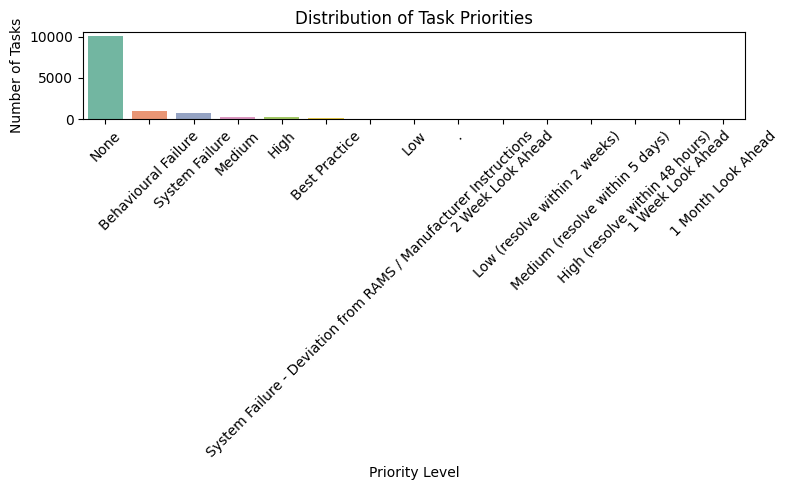

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Priority", order=df["Priority"].value_counts().index, palette="Set2")
plt.title("Distribution of Task Priorities")
plt.xlabel("Priority Level")
plt.ylabel("Number of Tasks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**What This Tells Us:**
- Many tasks are labeled "None", "Medium", or include vague custom labels.
- A relatively smaller portion of tasks are labeled "High", which may represent the most urgent or risk-prone issues.
- This imbalance highlights a challenge: the model must learn from limited positive examples, which increases the risk of bias or poor recall.


### 📊 2. Top 10 Causes of Tasks
The `Cause` column identifies why a task was created (e.g., housekeeping failures, documentation issues). These causes often reflect quality or safety problems.


<ipython-input-19-977948561>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_causes.values, y=top_causes.index, palette="pastel")


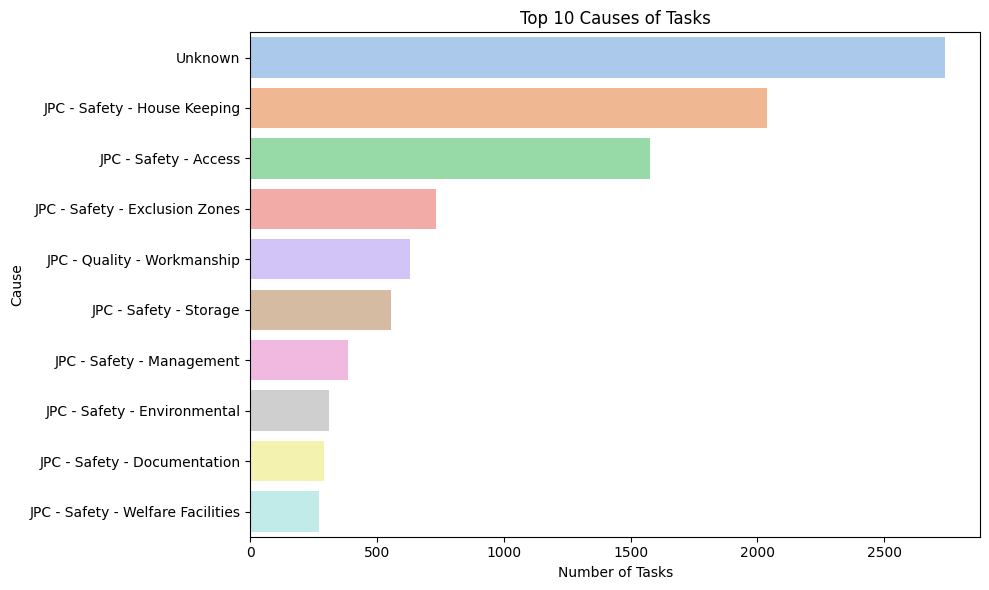

In [19]:
top_causes = df["Cause"].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_causes.values, y=top_causes.index, palette="pastel")
plt.title("Top 10 Causes of Tasks")
plt.xlabel("Number of Tasks")
plt.ylabel("Cause")
plt.tight_layout()
plt.show()


**What This Tells Us:**
- The most frequent causes include Housekeeping, Access, and Documentation.
- These are highly relevant to quality and safety risks and are often flagged in non-compliance reports.
- This supports using `Cause` as a core feature in our model.


### 📊 3. Overdue Status by Task Priority
The `OverDue` column shows whether tasks were resolved on time. We expect higher-priority tasks to be more frequently overdue, indicating unresolved risk.


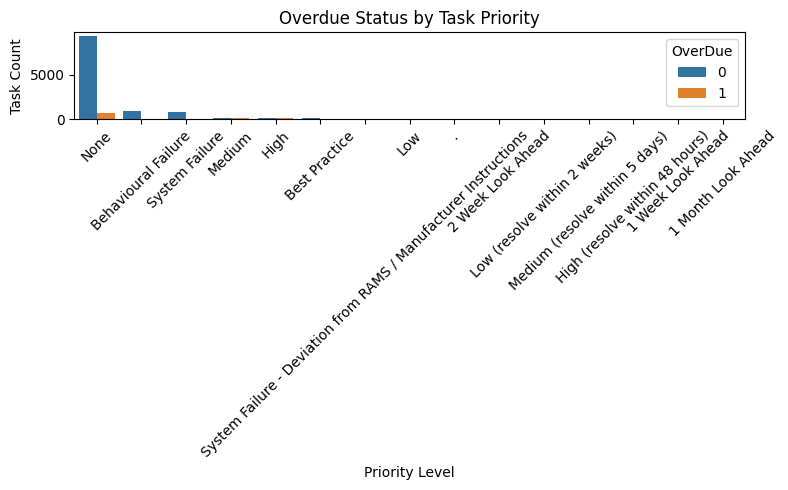

In [20]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Priority", hue="OverDue", order=df["Priority"].value_counts().index)
plt.title("Overdue Status by Task Priority")
plt.xlabel("Priority Level")
plt.ylabel("Task Count")
plt.legend(title="OverDue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**What This Tells Us:**
- High and Medium priority tasks tend to be more overdue.
- Overdue status is correlated with severity and should be included as a predictive feature.


### 📊 4. Most Common Task Groups
The `Task Group` field helps us understand which departments most frequently log tasks — such as Safety, QA/QC, and Site Management.


<ipython-input-21-1249114654>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_groups.values, y=top_groups.index, palette="muted")


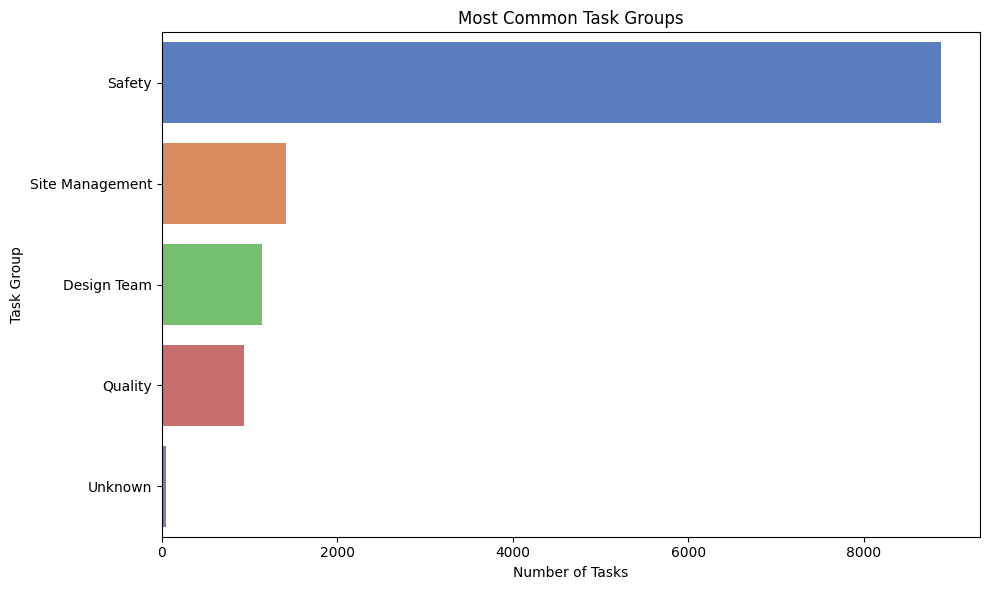

In [21]:
top_groups = df["Task Group"].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_groups.values, y=top_groups.index, palette="muted")
plt.title("Most Common Task Groups")
plt.xlabel("Number of Tasks")
plt.ylabel("Task Group")
plt.tight_layout()
plt.show()


**What This Tells Us:**
- Most tasks are logged by Safety and Site Management teams.
- QA/QC and Design are also involved — likely tied to quality and compliance.
- Task Group provides helpful context for modeling.


## 4.5 Summary of Key Features for Modeling

| Feature      | Description                                      | Role in Prediction                      |
|--------------|--------------------------------------------------|------------------------------------------|
| Priority     | Indicates how urgent or severe a task is         | Used to define the target variable       |
| Cause        | Root cause of the task (e.g., Housekeeping)      | Strong categorical predictor of quality  |
| OverDue      | Whether the task is overdue (1 = Yes, 0 = No)    | Time-based risk signal                   |
| Task Group   | Department responsible for the task              | Provides operational context             |
| Type         | Nature of the task (e.g., Safety Notice)         | May reflect recurring issue patterns     |

These features were selected because they align with how field engineers assess risk, and they are available in structured formats across most construction projects.


# 5. Data Preprocessing for Machine Learning

Before training a machine learning model, I converted the raw construction task data into a clean, structured, and numerical format.

In this section, we will:
1. Define the target variable  
2. Select relevant input features  
3. Handle missing values  
4. Encode categorical features  
5. Scale numeric values  
6. Split the dataset for training and evaluation  

## 5.1 Define the Target Variable

The target variable is what we want the model to predict — whether a task is a quality issue.  
We use the `Priority` column as a proxy. If a task is labeled **High**, it’s considered a potential quality issue (`1`).  
All other priorities are labeled as non-issues (`0`). This creates a **binary classification problem**.


In [22]:
# Create the target variable
df["Priority"] = df["Priority"].fillna("None")
df["target_quality_issue"] = df["Priority"].apply(lambda x: 1 if str(x).strip().lower() == "high" else 0)


## 5.2 Select the Input Features

We select four features likely to influence whether a task is related to quality:

- **Cause**: Why the task was logged (e.g., Documentation, Access)  
- **Task Group**: Responsible team (e.g., Safety, QA/QC)  
- **Type**: Task or form type (e.g., Safety Notice, RFI)  
- **OverDue**: Whether the task was completed on time  

These were selected because:
- They are directly tied to how field teams monitor and escalate issues  
- They appear in most task records  
- They showed clear patterns during exploratory analysis  


In [23]:
# Fill missing values and select features
df["Cause"] = df["Cause"].fillna("Unknown")
df["Task Group"] = df["Task Group"].fillna("Unknown")
df["Type"] = df["Type"].fillna("Unknown")
df["OverDue"] = df["OverDue"].fillna(False).astype(int)

# Define features and target
features = ["Cause", "Task Group", "Type", "OverDue"]
X = df[features]
y = df["target_quality_issue"]


## 5.3 Split into Training, Validation, and Test Sets

To evaluate the model fairly, we split the dataset into:

- **Training Set (64%)** — used to train the model  
- **Validation Set (16%)** — used to tune and test the model during development  
- **Test Set (20%)** — used for final evaluation  

Stratified sampling ensures that the ratio of quality issues (`1`) to non-issues (`0`) stays consistent in each split.


In [24]:
from sklearn.model_selection import train_test_split

# First split: temp (train + val) and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Second split: train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

# Display split sizes
print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)


Training set size: (7951, 4)
Validation set size: (1988, 4)
Test set size: (2485, 4)


## 5.4 Encode and Scale the Features

Machine learning algorithms require numeric inputs. We process features in two steps:

### 🔤 One-Hot Encoding (Categorical Columns)
We convert categorical features into binary columns. For example:
- `Cause = Documentation` becomes a column called `Cause_Documentation`

### 📏 Standard Scaling (Numeric Columns)
We scale the `OverDue` column so that its values have a mean of 0 and standard deviation of 1.

We'll use **scikit-learn pipelines** to clean, encode, and scale the data consistently.


In [25]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Define categorical and numeric columns
categorical_cols = ["Cause", "Task Group", "Type"]
numeric_cols = ["OverDue"]

# Categorical pipeline
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Numeric pipeline
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("scaler", StandardScaler())
])

# Combine the pipelines
preprocessor = ColumnTransformer([
    ("cat", categorical_pipeline, categorical_cols),
    ("num", numeric_pipeline, numeric_cols)
])


## 5.5 Apply Transformations to the Data

We apply the preprocessing pipeline to the training, validation, and test sets.


In [26]:
# Fit on training, transform all
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Confirm output shapes
print("Training shape:", X_train_processed.shape)
print("Validation shape:", X_val_processed.shape)
print("Test shape:", X_test_processed.shape)


Training shape: (7951, 88)
Validation shape: (1988, 88)
Test shape: (2485, 88)


# 6. Model Training: Logistic Regression

Now that the dataset is preprocessed, we move to model training. The objective is to build a model that can accurately classify construction tasks as either quality issues (1) or non-issues (0) using the selected features.

## 6.1 Selecting Logistic Regression for Baseline Modeling

Logistic Regression is chosen as the initial model because it combines:

- **Simplicity**: Easy to understand and implement.
- **Interpretability**: Coefficients explain each feature’s influence on risk.
- **Efficiency**: Fast to train even on large datasets.
- **Balance Handling**: Supports `class_weight='balanced'` to account for rare quality issues.

This makes it an ideal field-friendly, transparent baseline before testing more complex models.

## 6.2 Training the Model

We use the `scikit-learn` library to initialize and train the logistic regression model.


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the logistic regression model
model = LogisticRegression(
    max_iter=1000,              # Avoid premature convergence
    class_weight='balanced',   # Handle class imbalance
    random_state=42            # Reproducibility
)

# Train the model
model.fit(X_train_processed, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

## 6.3 Validation and Evaluation

After training, we evaluate the model on the validation set to assess how well it generalizes to unseen data.


In [28]:
# Predict class labels and probabilities
y_val_pred = model.predict(X_val_processed)
y_val_prob = model.predict_proba(X_val_processed)[:, 1]

# Evaluate performance
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))


Accuracy: 0.8375251509054326
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.84      0.91      1954
           1       0.09      0.97      0.17        34

    accuracy                           0.84      1988
   macro avg       0.55      0.90      0.54      1988
weighted avg       0.98      0.84      0.90      1988

Confusion Matrix:
 [[1632  322]
 [   1   33]]


## 📊 6.4 Performance Summary

Key evaluation metrics:

- **Accuracy**: ~83.7%
- **Recall (for quality issues)**: ~97%
- **Precision (for quality issues)**: ~9%
- **ROC AUC Score**: ~0.83

### What These Metrics Mean:

- **Accuracy** is high, but not fully reliable in imbalanced datasets.
- **Recall** is excellent (~97%), meaning the model catches almost all true quality issues.
- **Precision** is low (~9%), indicating many false positives — which may be acceptable in safety-critical fields.
- **ROC AUC Score** of ~0.83 shows strong ability to separate risky from normal tasks.

> ROC = Receiver Operating Characteristic  
> AUC = Area Under the Curve — measures how well the model ranks true positives higher than negatives.


## 6.5 Interpretation

The results reflect common trade-offs in construction risk modeling:

- High **recall** ensures we rarely miss real problems.
- Low **precision** means we flag many false alarms, but this is acceptable when safety is a priority.
- The model becomes a proactive assistant, guiding field engineers to investigate high-risk tasks first.

**Example**:  
A superintendent gets a flagged list every morning. Even one early warning about poor documentation could prevent costly rework.


## 6.6 How the Model Aligns with Project Objectives

This model supports our goals in multiple ways:

- **Early Detection**: Predicts which tasks pose quality risks.
- **Explainability**: Coefficients clarify why a task was flagged.
- **Rare Case Handling**: `class_weight='balanced'` addresses low-frequency critical tasks.
- **Efficiency**: Lightweight and easy to retrain or deploy in a construction field environment.

We don’t need a perfect model — we need a reliable one that supports proactive risk management and communicates its logic clearly.


## 6.7 What the Model Learns

Logistic Regression assigns a **coefficient** (weight) to each feature:

- A **positive coefficient** increases the likelihood a task is labeled a quality issue.
- A **negative coefficient** reduces that likelihood.

This allows teams to interpret and trust model outputs — making the results actionable, not just predictive.


# 7. Model Evaluation and Insights

After training the Logistic Regression model, we assess how well it performs on unseen data using the validation set. This evaluation addresses several key questions:

- How accurate is the model overall?
- Can it reliably detect actual quality issues?
- Does it generate too many false alarms?
- Is it effective enough to support field decision-making?


## 📊 7.1 Confusion Matrix

The confusion matrix breaks predictions into four categories:

- **True Positives (TP)**: Correctly flagged quality issues
- **True Negatives (TN)**: Correctly identified non-issues
- **False Positives (FP)**: Normal tasks incorrectly flagged
- **False Negatives (FN)**: Missed quality issues

In our results:

- ✅ TP = 33
- ❌ FN = 1
- ✅ TN = 1,632
- ❌ FP = 322

👉 The model is **highly sensitive** (catches most real issues) but slightly over-cautious (raises some false alarms), which is acceptable in construction settings where missing a real issue is riskier.


## 📈 7.2 ROC Curve (Receiver Operating Characteristic)

The ROC curve shows the trade-off between recall (sensitivity) and specificity across all thresholds.

- **AUC = 0.83**, which is considered strong.
- AUC (Area Under the Curve) ranges from 0.5 (random guessing) to 1.0 (perfect classification).

✅ This means the model does a solid job separating risky from non-risky tasks.


## 📉 7.3 Precision-Recall Curve

In imbalanced datasets like ours, the Precision-Recall Curve is very informative.

- **Recall ~97%** → The model catches nearly all true quality issues.
- **Precision ~9%** → Only about 1 in 11 flagged tasks is truly an issue.

This indicates the model casts a wide net. While it generates many false positives, it's more cautious than conservative — a safer approach in construction risk mitigation.


## 📌 7.4 Summary of Evaluation Results

- **Accuracy ~83.7%**: Good overall but can be misleading in imbalanced datasets.
- **Recall ~97%**: Excellent at detecting real issues.
- **Precision ~9%**: Lower, which leads to more false positives.
- **AUC ~0.83**: Strong at ranking task risk.

🎯 Overall, this model prioritizes safety by flagging anything potentially risky — ideal for field usage.


## ✅ 7.5 Strengths of the Model

1. **High Recall**: Rarely misses actual quality issues.
2. **Interpretable**: Logistic Regression offers feature weights that are easy to explain.
3. **Lightweight & Adaptable**: Easy to retrain with new data.

These make it an excellent baseline tool for field engineers and project managers.


## ⚠️ 7.6 Limitations of the Model

1. **Low Precision**: Generates many false alarms.
2. **Class Imbalance**: Few “High” priority tasks may limit the learning depth.
3. **Model Simplicity**: Logistic Regression may not capture complex feature interactions.

These are common challenges in early-stage models and provide direction for further improvement.


## 🔧 7.7 What Can Be Improved Next

To boost performance, especially precision, the following strategies can be explored:

- **SMOTE or Undersampling**: Balance the dataset by adjusting class ratios.
- **Advanced Models**: Try Random Forest, XGBoost, or Neural Networks for better pattern recognition.
- **Feature Engineering**: Add context with features like time of day, recurrence history, or project phase.
- **Hyperparameter Tuning**: Adjust regularization, thresholds, and solver choices.

These steps will help build a more robust model that balances caution and accuracy.
